In [2]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
from langsmith import traceable

# 환경 변수 로드
load_dotenv()

# Gemini API 키 설정
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [3]:
# Gemini 모델 초기화
model = genai.GenerativeModel('models/gemini-2.0-flash')

# 트레이싱이 가능한 wrapper 함수 생성
@traceable
def generate_with_gemini(prompt: str):
    response = model.generate_content(prompt)
    return response.text

# 테스트 실행
# result = generate_with_gemini('계란찜 만드는 방법을 알려줘')
# print(result)

In [4]:
# from IPython.display import Markdown

# Markdown(result)

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader
# 환경 변수 로드
load_dotenv()

# @traceable
def load_pdf(pdf_path: str):
    """
    PDF 파일을 로드하는 함수
    
    Args:
        pdf_path (str): PDF 파일의 경로
        
    Returns:
        list: Document 객체 리스트
    """
    try:
        # PDF 로더 초기화
        loader = PyMuPDFLoader(pdf_path)
        
        # PDF 로드
        documents = loader.load()
        
        print(f"PDF 로드 완료: {len(documents)} 페이지")
        return documents
    
    except Exception as e:
        print(f"PDF 로드 중 오류 발생: {str(e)}")
        return None

In [6]:
from glob import glob

current_dir = os.getcwd()

pdf_paths = glob(os.path.join(current_dir, "document", "*.pdf"))

In [7]:
import json

docs = []
for pdf_path in pdf_paths[-1:]:
    title = pdf_path.split('\\')[-1]
    print(f"PDF 로드 시작: {title}")
    documents = load_pdf(pdf_path)
    for document in documents:
        document.metadata['title'] = title
        docs.append(document)

PDF 로드 시작: 20250603_더불어민주당_정당정책.pdf
PDF 로드 완료: 20 페이지


In [8]:
print(len(docs))
docs

20


[Document(metadata={'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hwp 2018 11.0.0.2129', 'creationdate': '2025-05-10T16:18:26+09:00', 'source': 'c:\\Users\\LeeSeungYong\\myproject\\ai-agent\\agentic-rag\\document\\20250603_더불어민주당_정당정책.pdf', 'file_path': 'c:\\Users\\LeeSeungYong\\myproject\\ai-agent\\agentic-rag\\document\\20250603_더불어민주당_정당정책.pdf', 'total_pages': 20, 'format': 'PDF 1.4', 'title': '20250603_더불어민주당_정당정책.pdf', 'author': 'USER', 'subject': '', 'keywords': '', 'moddate': '2025-05-10T16:18:26+09:00', 'trapped': '', 'modDate': "D:20250510161826+09'00'", 'creationDate': "D:20250510161826+09'00'", 'page': 0}, page_content='- 1 -\n선거명\n제21대 대통령선거\n정당명\n더불어민주당\n정책순위 : 1\n세계를 선도하는 경제 강국을 만들겠습니다.\n분   야경제·산업\n□목 표 \n○AI 등 신산업 집중육성을 통해 새로운 성장기반 구축 \n○K-콘텐츠 지원강화로 글로벌 빅5 문화강국 실현\n□이행방법\n○인공지능 대전환(AX)을 통해 AI 3강으로 도약\n- AI 예산 비중 선진국 수준 이상 증액과 민간 투자 100조원 시대 개막\n- AI 데이터센터 건설을 통한 ‘AI 고속도로’ 구축 및 국가 혁신거점 육성\n- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성 \n- ‘모두의 AI’ 프로젝트 추진 및 규제 특례를 통한 AI 융복합

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document  # Document 클래스 import 추가
import re

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200,  # 더 큰 청크 사이즈
    chunk_overlap=50,  # 더 큰 오버랩
    model_name = "gpt-4"
)

# def preprocess_text(text):
#     # 불필요한 공백 제거
#     text = ' '.join(text.split())
#     # 특수문자 처리
#     text = re.sub(r'[^\w\s]', ' ', text)
#     return text

# # 문서 분할 전에 전처리 적용
# doc_splits = text_splitter.split_documents(
#     [Document(page_content=preprocess_text(doc.page_content)) for doc in docs]
# )
doc_splits = text_splitter.split_documents(docs)

In [10]:
import tiktoken

print(len(doc_splits))
# doc_splits[4].page_content.strip()
for i, split in enumerate(doc_splits):
    encoder = tiktoken.get_encoding("cl100k_base")
    tokens = encoder.encode(split.page_content)
    if '데이터센터' in split.page_content:
        print(f"{i+1}번째 Document 토큰 개수: {len(tokens)}")
        print(split.page_content)
        print()

106
2번째 Document 토큰 개수: 152
□이행방법
○인공지능 대전환(AX)을 통해 AI 3강으로 도약
- AI 예산 비중 선진국 수준 이상 증액과 민간 투자 100조원 시대 개막
- AI 데이터센터 건설을 통한 ‘AI 고속도로’ 구축 및 국가 혁신거점 육성
- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성



In [11]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers import EnsembleRetriever
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Gemini Embedding 모델 초기화
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # 더 강력한 임베딩 모델
    task_type="retrieval_document"  # 문서 검색에 최적화
)

# 벡터 스토어 생성
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=doc_splits,
#     embedding=embeddings
# )

faiss_vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)

In [12]:
faiss_vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)
faiss_retriever = faiss_vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

bm25_retriever = BM25Retriever.from_documents(doc_splits)
bm25_retriever.k = 5

# 5. 앙상블 검색기 생성
ensemble_retriever = EnsembleRetriever(
    retrievers=[faiss_retriever, bm25_retriever],
    weights=[0.3, 0.7]  # FAISS에 더 높은 가중치
)

In [14]:
from langchain.tools.retriever import create_retriever_tool

# 6. 검색 결과 디버깅 함수
def debug_ensemble_search(query, ensemble_retriever):
    print(f"\n=== 검색어: {query} ===")
    
    # 각 검색기의 결과도 확인
    print("\nFAISS 검색 결과:")
    faiss_results = faiss_retriever.invoke(query)
    for i, doc in enumerate(faiss_results, 1):
        print(f"\n문서 {i}:")
        print(f"내용: {doc.page_content[:200]}...")
    
    print("\nBM25 검색 결과:")
    bm25_results = bm25_retriever.invoke(query)
    for i, doc in enumerate(bm25_results, 1):
        print(f"\n문서 {i}:")
        print(f"내용: {doc.page_content[:200]}...")
    
    print("\n앙상블 검색 결과:")
    ensemble_results = ensemble_retriever.invoke(query)
    for i, doc in enumerate(ensemble_results, 1):
        print(f"\n문서 {i}:")
        print(f"내용: {doc.page_content[:200]}...")
        if hasattr(doc, 'metadata'):
            print(f"메타데이터: {doc.metadata}")
    
    return ensemble_results

# 7. 검색기 도구 생성
retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "policy_search",
    "각 정당의 정책을 검색해서 정보를 알려주세요."
)

# 8. 테스트
query = "소상공인 경제 활성화 대책에 대해서 설명해줘"
results = debug_ensemble_search(query, ensemble_retriever)


=== 검색어: 소상공인 경제 활성화 대책에 대해서 설명해줘 ===

FAISS 검색 결과:

문서 1:
내용: ○지속 가능한 노후 소득 보장 체계 구축
- 국민연금 수급 연령에 맞춘 정년 연장, 사회적 합의를 통해 단계적 추진
- 주택연금 제도개선 등을 통해 노후 소득 보장을 위한 지원강화...

문서 2:
내용: ○건축물·열 부문 탈탄소화
- 민간·공공 그린리모델링 지원 확대 및 절차 간소화를 통한 노후건물 에너지효율화
○전기차 보급 확대 및 노후경유차 조기 대·폐차 지원을 통한 수송부문 탈탄소 가속화...

문서 3:
내용: ○국가첨단전략산업에 대한 대규모 집중투자방안 마련
- 국민·기업·정부·연기금 등 모든 경제주체들이 참여할 수 있는 국민펀드 조성
- 일반국민·기업의 투자금에 대해 소득세·법인세 감면 등 과감한 세제혜택 부여
- 산업생태계 뒷받침을 위한 기금을 설치하여 맞춤형 자금공급 지원...

문서 4:
내용: ○의료 대란 해결 및 의료 개혁 추진
□이행방법
○범죄로부터 안전한 사회 구축
- 흉악범죄·묻지마범죄(이상동기범죄) 예방을 위해 범죄경력자 관리 감독 강화
- 교제폭력 범죄 처벌 강화 및 피해자 보호명령제도 도입
- 청소년 범죄 대응체계 강화...

문서 5:
내용: ○동일노동 동일임금 기준지표 마련을 위한 임금분포제 도입
○산업․업종․지역단위 단체교섭협약 활성화로 저임금노동자들의 기본 노동조건 보장
- 국가․지자체, 공공기관 등 공공부문이 모범적 사용자로서 노동관계법 준수 및 산
업․업종 단체교섭협약모델 구축 추진...

BM25 검색 결과:

문서 1:
내용: ○공정하고 지속가능하며 실패해도 재기할 수 있는 소상공인 경제 구축
- ‘소상공인 내일채움공제’ 도입으로 목돈 마련 기회 제공
- 폐업지원금 현실화 및 폐업시 대출금 일시상환 유예 요건 완화
○소상공인·자영업자 사회안전망 확대
- 경찰청 연계 안심콜 의무화로 여성 소상공인 안전 강화 
- 소상공인·자영업자 육아휴직수당 확대...

문서 2:
내용: - 12 -
- 국민휴가 지원 

In [15]:
from IPython.display import display, Markdown

def print_documents(documents):
    """
    검색된 문서들을 보기 좋게 출력하는 함수
    """
    for i, doc in enumerate(documents, 1):
        # 마크다운 형식으로 출력
        display(Markdown(f"""
### 문서 {i}
---
{doc.page_content}
---
        """))
        
        # 메타데이터가 있다면 출력
        if doc.metadata:
            print("\n메타데이터:")
            for key, value in doc.metadata.items():
                if key == "title":
                    print(f"- {key}: {value}")
        print("\n" + "="*80 + "\n")  # 구분선

In [16]:
# 사용 예시
# print_documents(relevant_documents)

In [17]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model(
    "google_genai:gemini-2.0-flash",
    temperature=0
)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    # print(type(state["messages"]), state["messages"])
    response = (
        response_model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [18]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
response = generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [19]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "더불어민주당의 '청년미래적금' 정책에 대해 자세히 알려주세요. 어떤 내용이고, 누가 대상이며, 어떤 효과를 기대하는지 설명해주세요.",
        }
    ]
}
response = generate_query_or_respond(input)

In [20]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

더불어민주당의 '청년미래적금' 정책에 대한 자세한 내용은 정책 검색을 통해 확인해볼 수 있습니다. 어떤 내용인지, 대상은 누구인지, 어떤 효과를 기대하는지 등을 알아보기 위해 검색을 실행하겠습니다.
Tool Calls:
  policy_search (d6d1e084-8129-4b77-a611-752721ffd6d0)
 Call ID: d6d1e084-8129-4b77-a611-752721ffd6d0
  Args:
    query: 더불어민주당 청년미래적금


In [21]:
response["messages"][-1]

AIMessage(content="더불어민주당의 '청년미래적금' 정책에 대한 자세한 내용은 정책 검색을 통해 확인해볼 수 있습니다. 어떤 내용인지, 대상은 누구인지, 어떤 효과를 기대하는지 등을 알아보기 위해 검색을 실행하겠습니다.", additional_kwargs={'function_call': {'name': 'policy_search', 'arguments': '{"query": "\\ub354\\ubd88\\uc5b4\\ubbfc\\uc8fc\\ub2f9 \\uccad\\ub144\\ubbf8\\ub798\\uc801\\uae08"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--58c2e31a-df39-47d8-8538-13ead7bf5346-0', tool_calls=[{'name': 'policy_search', 'args': {'query': '더불어민주당 청년미래적금'}, 'id': 'd6d1e084-8129-4b77-a611-752721ffd6d0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens': 89, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}})

In [22]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model(
    "google_genai:gemini-2.0-flash", 
    temperature=0
    )


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [23]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [24]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": """
더불어 민주당 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 
장기적인 세수 확보 가능        
            """, "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'generate_answer'

In [25]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question IN KOREAN(HANGUL):"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [26]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)

In [27]:
print(response["messages"][-1]["content"])

더불어민주당의 주요 경제 정책 목표와 구체적인 정책 내용, 그리고 그 정책들이 한국 경제에 미칠 영향에 대해 자세히 설명해 주세요.


In [28]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [29]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 뭐가 있는지 찾아줘",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": """
더불어 민주당 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 
장기적인 세수 확보 가능        
            """, "tool_call_id": "1"},
        ]
    )
}
response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

더불어민주당은 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 장기적인 세수 확보를 목표로 합니다. 다른 구체적인 경제 정책에 대한 정보는 제공된 문맥에서 찾을 수 없습니다.


In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

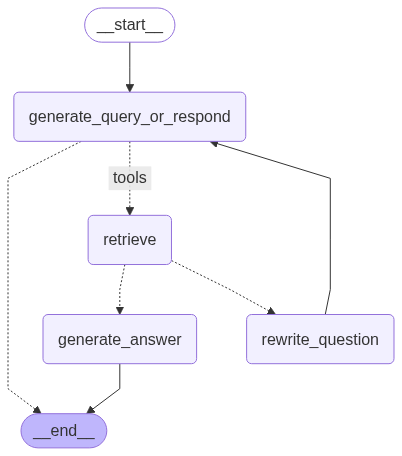

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
from typing import Dict

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "더불어 민주당의 주요 AI 정책이 뭔지 설명해줘",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        if isinstance(update["messages"][-1], Dict):
            print(update["messages"][-1]['content'])
        else:
            update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  policy_search (221450e8-a0c9-4d84-af43-d9ef6771afb1)
 Call ID: 221450e8-a0c9-4d84-af43-d9ef6771afb1
  Args:
    query: 더불어 민주당 AI 정책



Update from node retrieve
================================= Tool Message =================================
Name: policy_search

□재원조달방안 등
○정부재정 지출구조 조정분, 2025~2030 연간 총수입증가분(전망) 등으로 충당

□이행방법
○인공지능 대전환(AX)을 통해 AI 3강으로 도약
- AI 예산 비중 선진국 수준 이상 증액과 민간 투자 100조원 시대 개막
- AI 데이터센터 건설을 통한 ‘AI 고속도로’ 구축 및 국가 혁신거점 육성
- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성

- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성 
- ‘모두의 AI’ 프로젝트 추진 및 규제 특례를 통한 AI 융복합 산업 활성화
- AI 시대를 주도할 미래인재 양성 교육 강화
○대한민국의 미래성장을 위한 글로벌 소프트파워 Big5 문화강국을 실현

- 교통물류환경종사자 근로여건 개선방안 마련
- 생활물류, 고속철도, 항공 등 국민편익 향상 방안 마련
○청년·근로자 천원의 아침밥 및 농식품바우처 확대 등 먹거리 돌봄 강화
○사람과 동물이 더불어 행복한 사회 조성
- 반려동물 양육비 부담 완화 및 의료 서비스 강화

- 청년 맞춤형 공공분양 및 월세지원 확대 등 청년 주거지원 강화
- 국민연금 군복무 크레딧 확대 등 청년생활안전망 구축
- 